In [43]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from arch import arch_model
import itertools  
import warnings
from scipy.optimize import OptimizeWarning
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import timedelta

# https://towardsdatascience.com/garch-google-getting-along-good-gg-aaaefff2e498


In [19]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)

Realizamos el Scrap


Las líneas verticales punteadas separan el dataset en años desde el 2015 al 2020

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


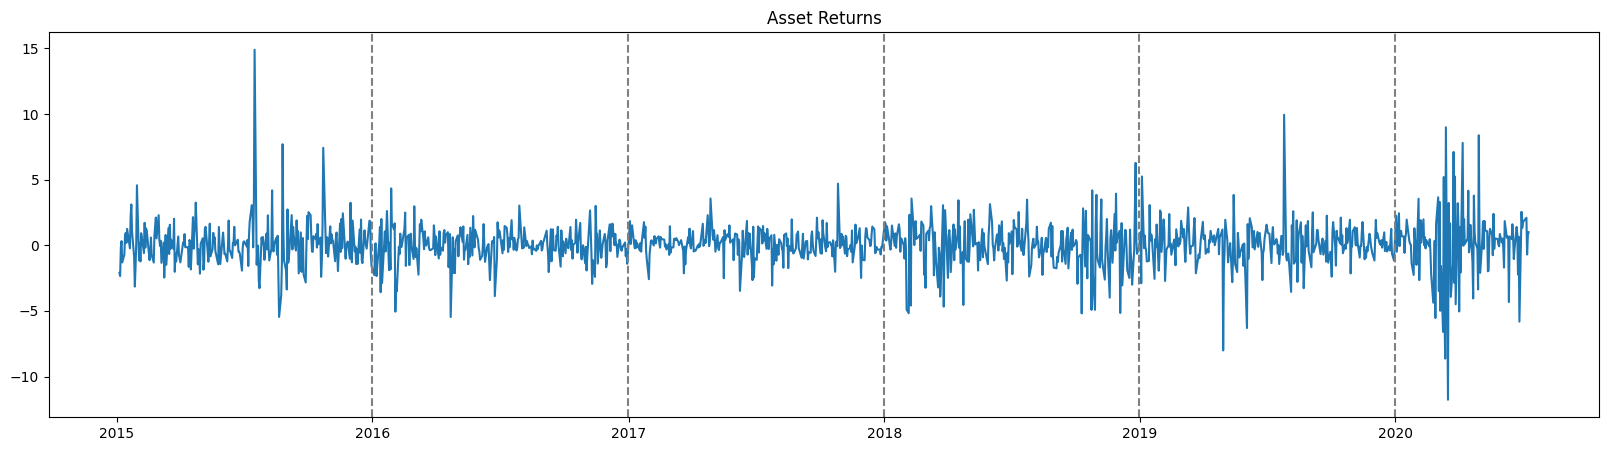

In [24]:
def returns(tickers,start,end):
    data = yf.download(tickers,start,end)['Close']
    data_return = np.log(data/data.shift(1)).dropna()
    return data_return

goog_return = returns('GOOG','2015-1-1','2020-7-10')
goog_return_rescaled = yf.download('GOOG', start = '2015-1-1',end='2020-7-10')
df_goog_shifted = goog_return_rescaled.Close.shift(1)
goog_return_rescaled['Return'] = np.log(goog_return_rescaled.Close/df_goog_shifted).mul(100)
goog_return_rescaled.dropna(inplace = True)
yr = pd.date_range(start = '2015', end = '2020' , freq = 'Y')
ret = goog_return_rescaled['Return']
fig = plt.figure()
plt.plot(ret)
plt.title("Asset Returns")
for i in yr:
    plt.axvline(i, linestyle = '--' , color = 'gray')
# plt.rcParams["figure.figsize"] = 20,5
# fig, axes = plt.subplots(1, 2)

# axes[0].plot(goog_return)
# axes[0].set_title('Asset Return')

# axes[1].plot(goog_return_rescaled)
# axes[1].set_title('Asset Return Rescaled')

# plt.show()

Corroboramos si la serie es estacionaria

In [11]:
p_val = adfuller(goog_return)[0]
print(f' El p valor es el siguiente {p_val}')

 El p valor es el siguiente -13.166102111114148


Realizamos los gráficos de autocorrelación y autocorrelación parcial

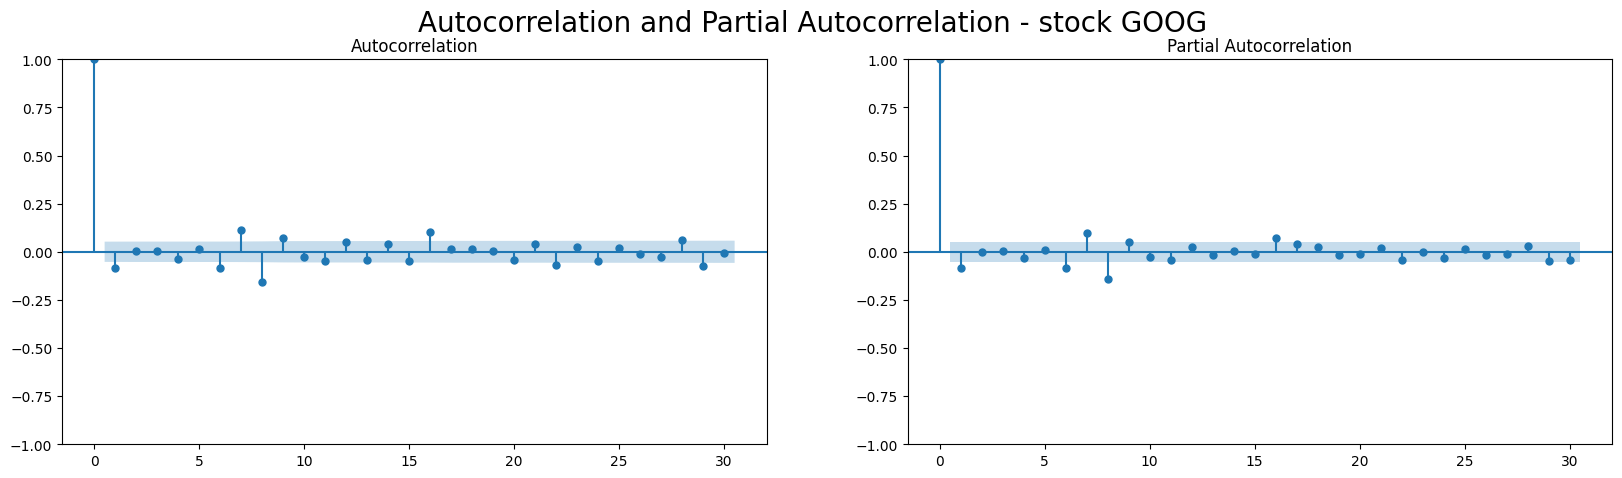

In [12]:
plt.rcParams["figure.figsize"] = 20, 5
fig,axes = plt.subplots(1,2)
acf = plot_acf(goog_return, lags=30, ax = axes[0])
pacf = plot_pacf(goog_return, lags=30, ax = axes[1], method='ywm')
acf.suptitle(f'Autocorrelation and Partial Autocorrelation - stock {"GOOG"}', fontsize=20)
plt.show()

In [5]:
# model = arch_model(goog_return*1 , p = 9, q = 9, dist = 't', rescale=False).fit(disp='off')
# model.summary()

Generamos un dataframe con valores de p y q en un rango de 1-9

In [20]:
data = []
for p, q in itertools.product(range(1, 10), range(1, 10)):
    model = arch_model(goog_return, p=p, q=q, dist='t',rescale=False).fit(disp='off')
    aic = model.aic
    data.append([p,q,aic])

data = pd.DataFrame(data,columns = ['p','q','AIC'])
data    
# data = []
# for p, q in itertools.product(range(1, 10), range(1, 10)):
#     model = arch_model(goog_return, p=p, q=q, dist='t',rescale=False).fit(disp='off')
#     aic = model.aic
#     data.append([p,q,aic])

# data = pd.DataFrame(data,columns = ['p','q','AIC'])
# data    
    # print(f"AIC({p},{q}): {model.aic}")



C:\Users\Renzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Renzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Renzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmi

,p,q,AIC
0,1,1,-5435.113942
1,1,2,-5532.284279
2,1,3,-6022.557113
3,1,4,-7172.353092
4,1,5,-5142.588545
...,...,...,...
76,9,5,256327.221603
77,9,6,-5424.654769
78,9,7,1306.692468
79,9,8,-7776.177565


Tratamos de encontrar la combinación de p y q que da el menor AIC

In [21]:
data_min = data.loc[data['AIC'].idxmin()]
data_min

p         9.000000
q         8.000000
AIC   -7776.177565
Name: 79, dtype: float64

Ahora hacemos lo mismo que hicimos con lo anterior pero con valores rescalados

In [8]:
data2 = []
dists = ['normal','t','skewt','ged']
for p, q in itertools.product(range(1, 6), range(1, 6)):
    model = arch_model(goog_return*100, p=p, q=q, dist='t').fit(disp='off')
    aic = model.aic
    data2.append([p, q, aic])

    


data2 = pd.DataFrame(data2,columns = ['p','q','AIC'])
# data2    

Vemos que combinación de p y q es la que da el menor AIC pero con valores rescalados

In [9]:
data2_min = data2.loc[data2['AIC'].idxmin()]
data2_min

p         1.000000
q         1.000000
AIC    8105.866776
Name: 0, dtype: float64

Ahora generamos un dataframe pero tratando de corroborar que distribución es la más adecuada, ya que por default es una distribución T

In [10]:
# data_normal = []
# dists = ['normal','t','skewt','ged']
# data_dists = {dists [] for dist in dists}
# for p, q in itertools.product(range(1, 10), range(1, 10)):
#     for dist in dists:
#         model = arch_model(goog_return*100, p=p, q=q, dist=dist).fit(disp='off')
#         aic = model.aic
#         data_dists[dist].append([p, q, aic])
    
# data_dists = pd.DataFrame(data_dists, columns=['p', 'q', 'AIC'])

# data_normal = pd.DataFrame(data_normal,columns = ['p','q','AIC'])
dists = ['normal', 't', 'skewt', 'ged']
data_frames = {}

for dist in dists:
    data_dists = []
    for p, q in itertools.product(range(1, 10), range(1, 10)):
        model = arch_model(goog_return, p=p, q=q, dist=dist).fit(disp='off')
        aic = model.aic
        data_dists.append([p, q, aic])
    data_frames[dist] = pd.DataFrame(data_dists, columns=['p', 'q', 'AIC'])
   

C:\Users\Renzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Renzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Renzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for

Buscamos el mínimo AIC pero teniendo en cuenta las distintas dists.

In [11]:
normal_dist = data_frames['normal']
t_dist = data_frames['t']
skewt_dist = data_frames['skewt']
ged_dist = data_frames['ged']
distr = {'normal':normal_dist.loc[normal_dist['AIC'].idxmin()],
         't':t_dist.loc[t_dist['AIC'].idxmin()],
         'skewt':skewt_dist.loc[skewt_dist['AIC'].idxmin()],
         'ged':ged_dist.loc[ged_dist['AIC'].idxmin()]}

distr = pd.DataFrame(distr)
distr

,normal,t,skewt,ged
p,1.000000,7.000000,7.000000,1.000000
q,4.000000,1.000000,9.000000,2.000000
AIC,-11779.106381,-12088.240251,-11563.279652,-11999.431676


In [12]:
normal_dist = data_frames['normal']
t_dist = data_frames['t']
skewt_dist = data_frames['skewt']
ged_dist = data_frames['ged']
distr_1 = {'normal':normal_dist.loc[normal_dist['AIC'].idxmin()],
         't':t_dist.loc[t_dist['AIC'].idxmin()],
         'skewt':skewt_dist.loc[skewt_dist['AIC'].idxmin()],
         'ged':ged_dist.loc[ged_dist['AIC'].idxmin()]}

distr_1 = pd.DataFrame(distr)
distr_1

,normal,t,skewt,ged
p,1.000000,7.000000,7.000000,1.000000
q,4.000000,1.000000,9.000000,2.000000
AIC,-11779.106381,-12088.240251,-11563.279652,-11999.431676


Tomamos una ventana de 5 veces el número de días de negociación al año (es decir, 252) y utilizamos los datos históricos para entrenar nuestro modelo. Se genera un gráfico de los rendimientos junto con los valores previstos. Tras ajustar un modelo mediante la función arch_model, utilizamos el método .forecast() para predecir el valor inmediato siguiente estableciendo el parámetro horizon = 1. Para ser precisos, se realiza una previsión de ventana móvil de 1 día. Hay que tener en cuenta que necesitamos encontrar la desviación estándar, por lo que tomamos la raíz cuadrada de la varianza pronosticada.

Probé con un ARCH(1,1)

Text(0.5, 1.0, 'Rolling Window Forecast')

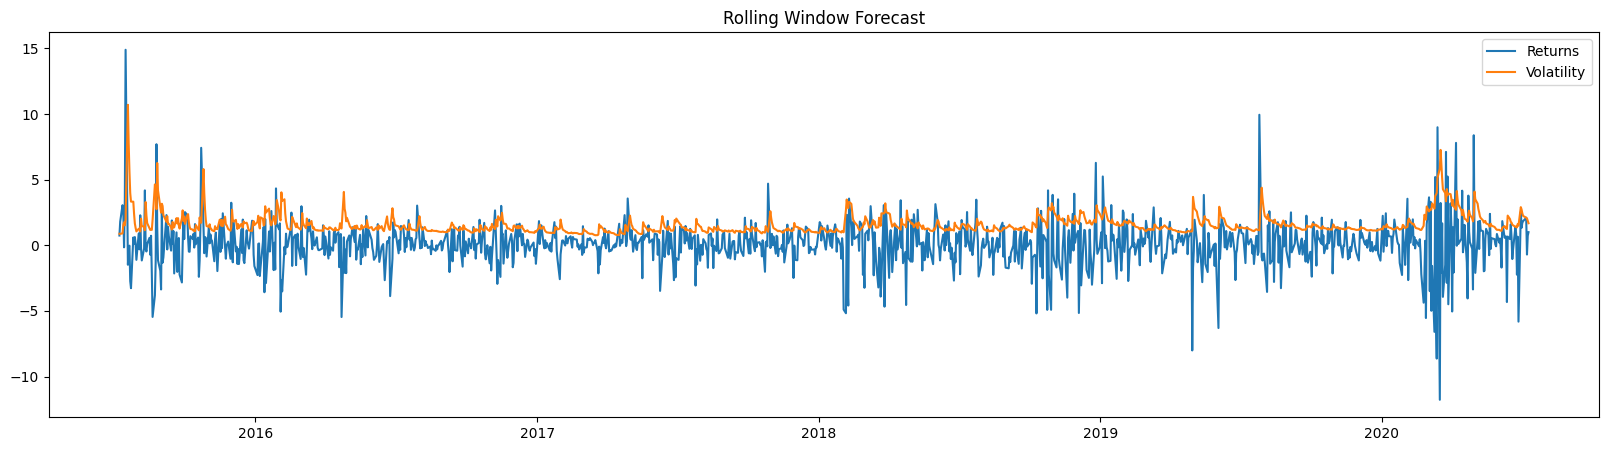

In [9]:
rolling = []
window = 252*5
for i in range(window):
    train_data = ret[:-(window-i)]
    model = arch_model(train_data, p = 1, q = 1).fit(disp='off')
    pred = model.forecast(horizon = 1)
    rolling.append(np.sqrt(pred.variance.values)[-1,:][0])
rolling = pd.Series(rolling , index = ret.index[-window:])
plt.plot(ret[-window:])
plt.plot(rolling)
plt.legend(['Returns','Volatility'])
plt.title('Rolling Window Forecast')

Luego probé con los parametros p y q que me retorno el menor AIC pero con los retornos sin re escalar.

C:\Users\Renzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Renzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Renzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmi

Text(0.5, 1.0, 'Rolling Window Forecast')

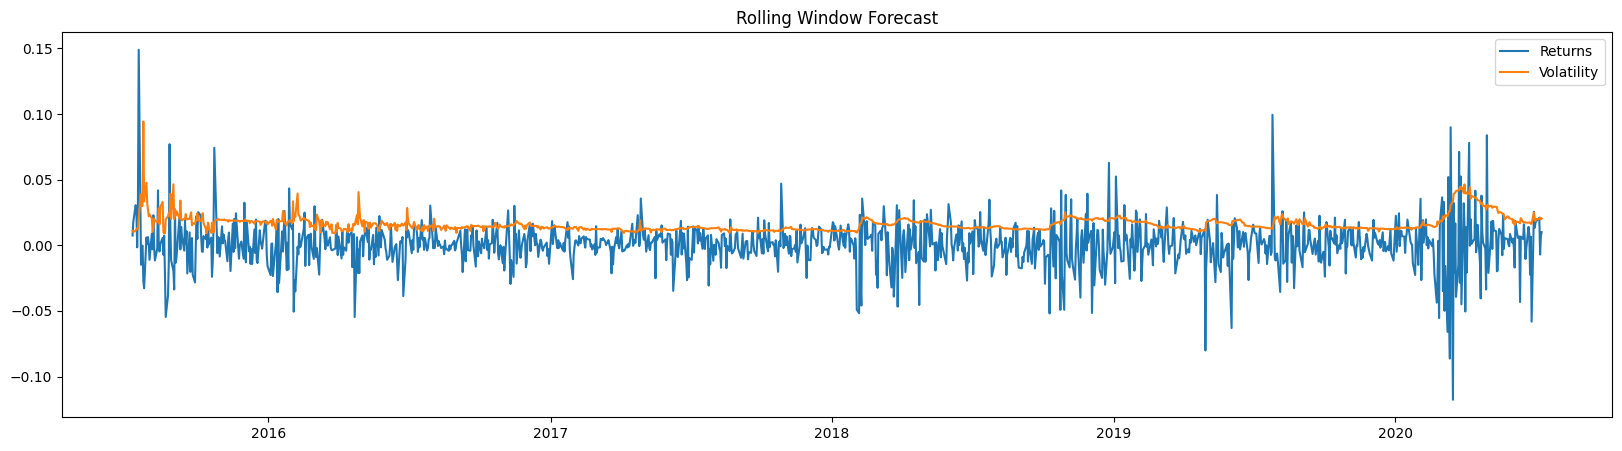

In [22]:
rolling = []
window = 252*5
for i in range(window):
    train_data = goog_return[:-(window-i)]
    model = arch_model(train_data, p = 9, q = 8).fit(disp='off')
    pred = model.forecast(horizon = 1)
    rolling.append(np.sqrt(pred.variance.values)[-1,:][0])
rolling = pd.Series(rolling , index = goog_return.index[-window:])
plt.plot(goog_return[-window:])
plt.plot(rolling)
plt.legend(['Returns','Volatility'])
plt.title('Rolling Window Forecast')



Validación del modelo
Matemáticamente, un residuo estándar es un residuo dividido por su desviación estándar. Es una medida de la fuerza de la diferencia entre los valores observados y los esperados. El residuo estándar debe seguir un proceso de ruido blanco; un proceso en el que las variables no están correlacionadas serialmente (son independientes entre sí en cualquier retardo), tienen una media cero y una varianza finita. Aquí utilizaremos tres técnicas de validación:

a) trazar los residuos estandarizados para ver intuitivamente si los residuos siguen un proceso de ruido blanco. Aquí, los residuos estandarizados, std_resid se calcula mediante el uso de .resid y .conditional_volatility atributos de nuestro objeto modelo como se muestra en el código siguiente.

b) trace un auto correlograma para verificar que los residuos estándar no están significativamente correlacionados en ningún lag. En el gráfico no se observa ningún retardo significativo distinto del retardo cero.

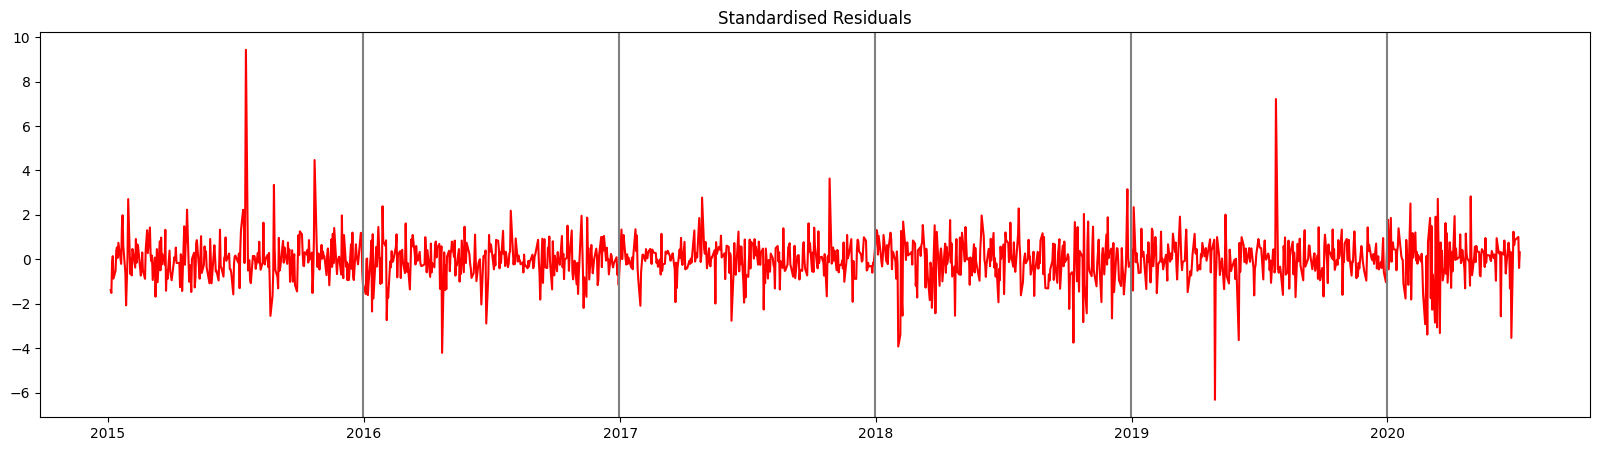

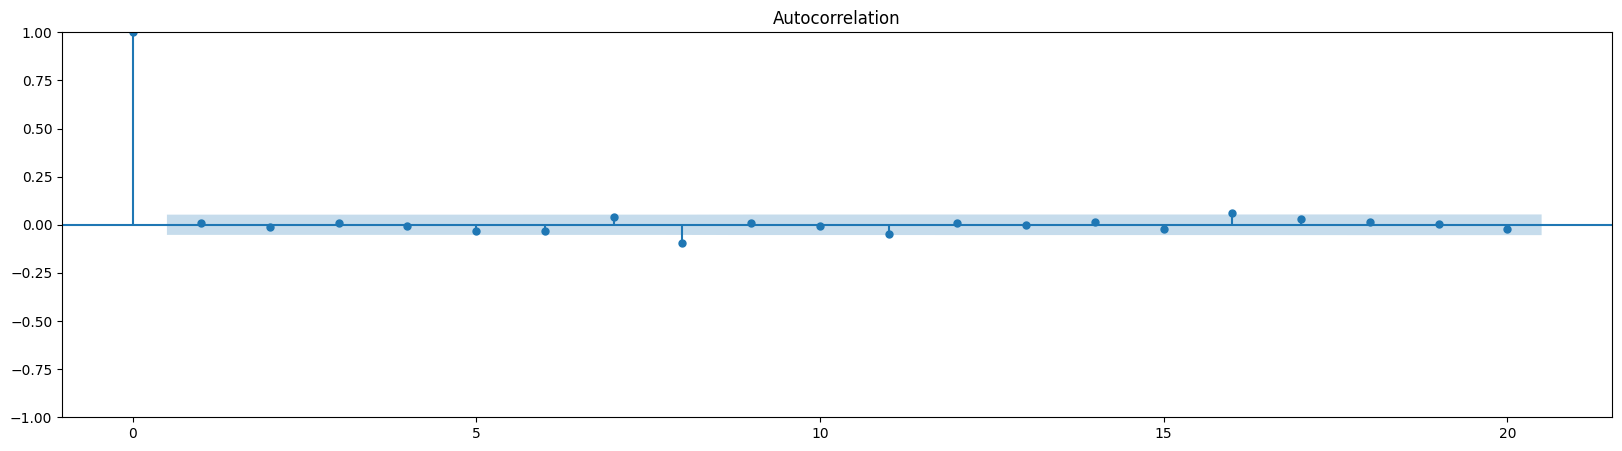

In [31]:
std_resid = model.resid/model.conditional_volatility
# fig, ax = plt.subplots(nrows = 2, ncols = 1)
plt.plot(std_resid, color = 'r')
plt.title('Standardised Residuals')
for i in yr:
    plt.axvline(i, linestyle = '-' , color = 'gray')
plot_acf(std_resid,lags = 20)
plt.show()

C)Realice una prueba de Ljung-Box. La motivación de esta prueba no es sólo comprobar la aleatoriedad en distintos retardos como en el caso b, sino que nos da una idea de la aleatoriedad global de las variables basada en el número especificado de retardos. Hipótesis nula: los datos se distribuyen de forma independiente. El valor p en cada retardo es superior al 5%, lo que sugiere que no se rechaza la hipótesis nula.

In [42]:
lb_test = acorr_ljungbox(std_resid, lags = 20)
lb_test.iloc[:, 1:] #gives us the p-values at each lag

,lb_pvalue
1,0.773284
2,0.871033
3,0.945016
4,0.975345
5,0.842659
6,0.769862
7,0.612637
8,0.020958
9,0.033300
10,0.050776


Pronosticamos la volatilidad en una ventana de 7 días


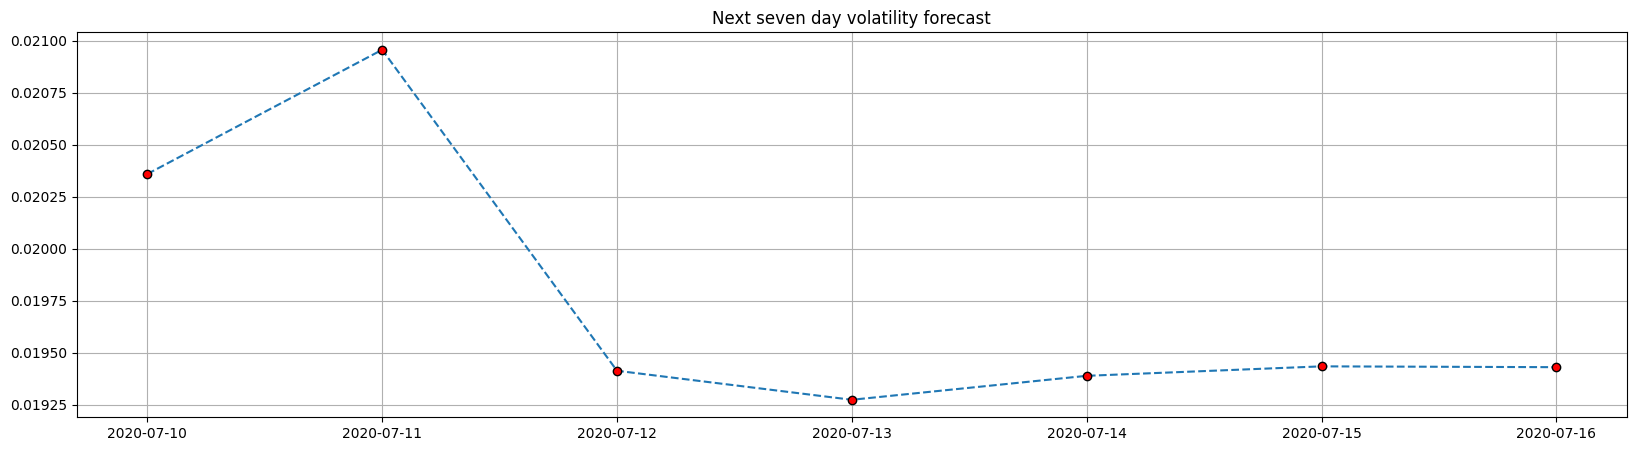

In [46]:
future_index = pd.date_range(start = (goog_return.index[-1]+timedelta(1)), periods = 7, freq = 'D')
predict = model.forecast(horizon = 7)
pred_vol = np.sqrt(predict.variance.values[-1:][0])
pred_vol = pd.Series(pred_vol,index = future_index)
plt.plot(pred_vol, marker = 'o', markerfacecolor = 'r', linestyle = '--', markeredgecolor = 'k', markersize = 6)
plt.title("Next seven day volatility forecast")
plt.grid(True)